# Kernel EDMD

This notebook illustrates how to use kernel extended dynamic mode decomposition (kernel EDMD) <cite data-cite="nbkedmd-williams2016kernel">(Williams, 2016)</cite> to compute eigenfunctions of the Koopman operator and Perron-Frobenius operator.

An alternative derivation of kernel EDMD using covariance and cross-covariance operators defined on reproducing kernel Hilbert spaces, highlighting also relationships with conditional mean embeddings of distributions and the Perron-Frobenius operator, is presented in <cite data-cite="nbkedmd-klus2019eigendecomposition">(Klus, 2019)</cite>. High-dimensional molecular dynamics problems can be found in <cite data-cite="nbkedmd-klus2018kernel">(Klus, 2018)</cite>.

Given training data $\{x_i\}_{i=1}^m$ and $\{y_i\}_{i=1}^m$, where $y_i$ is a time-lagged version of $x_i$, let $\varphi$ denote an eigenfunction and $\lambda$ the corresponding eigenvalue. For the Perron-Frobenius operator, we obtain kernel-based approximations of eigenvalues and eigenfunctions by
$$(G_{XX}+m\varepsilon I)^{-1}G_{XY} \mathbf{v} = \lambda \mathbf{v}, \quad \varphi = \Phi G_{XX}^{-1} \mathbf{v}$$
and for the Koopman operator by
$$(G_{XX} + m \varepsilon I)^{-1} G_{YX} \mathbf{v} = \lambda \mathbf{v}, \quad \varphi = \Phi \mathbf{v},$$
where $\Phi=[\phi(x_1), \dots, \phi(x_m)]$ is the so-called *feature matrix* and $\varepsilon$ a regularization parameter. The matrices $G_{XX}$ and $G_{XY}$ are the standard Gram matrix and the time-lagged Gram matrix, respectively, with entries $[G_{XX}]_{ij} = k(x_i, x_j)$ and $[G_{XY}]_{ij} = k(x_i, y_j)$. Moreover, $G_{YX}=G_{XY}^\top$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import deeptime as dt

First we define a dynamical system. We will use a quadruple-well problem as our guiding example, which is given by a stochastic differential equation of the form $$\mathrm{d}X_t = -\nabla V(X_t) \mathrm{d}t + \sqrt{2 \beta^{-1}} \mathrm{d}W_t.$$ The potential $V$ is defined by $$V(x) = (x_1^2 - 1)^2 + (x_2^2 - 1)^2 .$$ We define the inverse temperature to be $\beta = 4$. Let us visualize the potential.

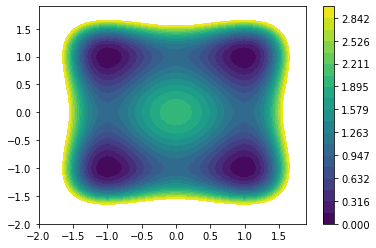

In [2]:
xy = np.arange(-2, 2, 0.1)
XX, YY = np.meshgrid(xy, xy)
V = (XX**2 - 1)**2 + (YY**2 - 1)**2
plt.contourf(xy, xy, V, levels=np.linspace(0.0, 3.0, 20))

plt.colorbar();

The dynamical system itself is implented in C++ for the sake of efficiency. The SDE is solved with the Euler-Maruyama method.

To visualize the system's dynamics we generate one long trajectory and plot a histogram. The density is high where the potential is low and vice versa. A particle will typically stay in one well for a long time before it transitions to other wells. There are thus four metastable states corresponding to the four wells.

We can load the model as follows.

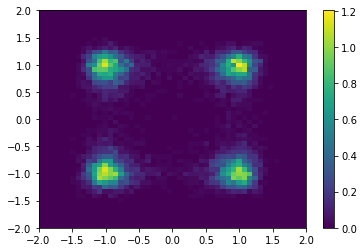

In [3]:
h = 1e-3 # step size of the Euler-Maruyama integrator
n_steps = 10000 # number of steps, the lag time is thus tau = nSteps*h = 10
x0 = np.zeros((1, 2)) # inital condition
n = 10000 # number of evaluations of the  discretized dynamical system with lag time tau

f = dt.data.quadruple_well(n_steps=n_steps)  # loading the model
traj = f.trajectory(x0, n, seed=42)

plt.hist2d(*traj.T, range=[[-2, 2], [-2, 2]], bins=50, density=True)
plt.colorbar()

To approximate the Koopman operator, we uniformly sample training data in $[-2, 2] \times [-2, 2]$.

In [4]:
m = 2500 # number of training data points
X = np.random.uniform(-2, 2, size=(2500, 2)) # training data
# X = 4*np.random.rand(2, m)-2 
Y = f(X, seed=42, n_jobs=1) # training data mapped forward by the dynamical system

We define a Gaussian kernel with bandwidth $\sigma=1$ and apply kernel EDMD to the data set.

In [5]:
sigma = 1 # kernel bandwidth
kernel = dt.kernels.GaussianKernel(sigma)

n_eigs = 6 # number of eigenfunctions to be computed
kedmd_estimator = dt.decomposition.KernelEDMD(kernel, n_eigs=n_eigs, epsilon=1e-3)
kedmd_model = kedmd_estimator.fit((X, Y)).fetch_model()

phi = np.real(kedmd_model.transform(X))

# normalize
for i in range(n_eigs):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

We expect four eigenvalues close to one. These dominant eigenvalues correspond to the slow dynamics. The eigenfunction of the Koopman operator associated with the eigenvalue $\lambda=1$ is the constant function, and the eigenfunction of the Perron-Frobenius operator associated with this eigenvalue is the invariant density.

Text(0.5, 1.0, 'Dominant eigenvalues')

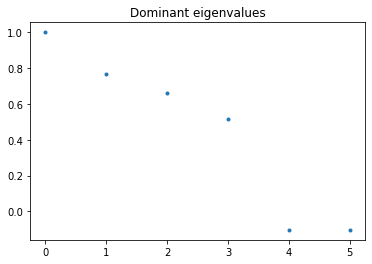

In [6]:
d = np.real(kedmd_model.eigenvalues)
plt.plot(d, '.')
plt.title('Dominant eigenvalues')

The eigenfunctions contain information about the metastable sets and slow transitions.

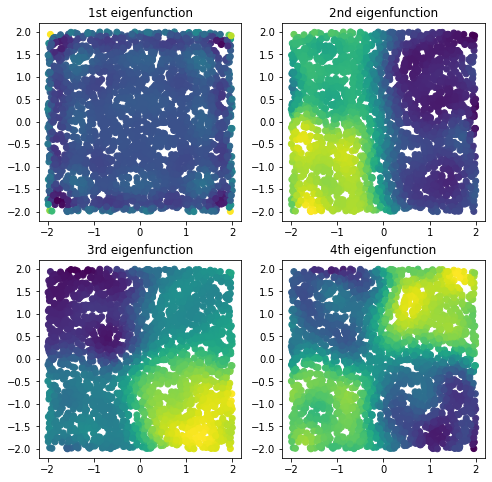

In [7]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(ncols=2, nrows=2)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(*X.T, c=phi[:, 0])
ax.set_title('1st eigenfunction')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(*X.T, c=phi[:, 1])
ax.set_title('2nd eigenfunction')

ax = fig.add_subplot(gs[1, 0])
ax.scatter(*X.T, c=phi[:, 2])
ax.set_title('3rd eigenfunction')

ax = fig.add_subplot(gs[1, 1])
ax.scatter(*X.T, c=phi[:, 3])
ax.set_title('4th eigenfunction');

We can now apply clustering techniques to the dominant eigenfunctions to obtain metastable sets.

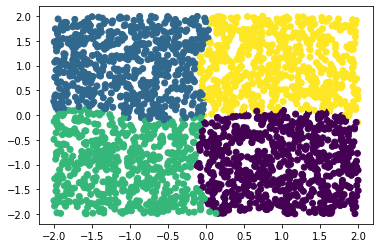

In [8]:
kmeans = dt.clustering.Kmeans(n_clusters=4, n_jobs=4).fit(phi[:, :4]).fetch_model()
c = kmeans.transform(phi[:, :4])

plt.scatter(*X.T, c=c)